## Load libraries

In [1]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from numba import njit, prange, jit
import sklearn
import imblearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import scipy.stats as ss
import sys
mod = sys.modules[__name__]
import inspect
import glob
import os
from time import perf_counter
import matplotlib.pyplot as plt

## Methods

In [2]:
@njit(parallel=True, fastmath=True)
def euclidean_distance(A, B):
    n_A, n_B = A.shape[0], B.shape[0]
    n_feat = B.shape[1]
    
    dist = np.empty(shape=(n_A, n_B), dtype=A.dtype)

    for i0 in prange(n_A):
        for i1 in prange(n_B):
            val = 0.
            for i2 in prange(n_feat):
                temp = A[i0, i2] - B[i1, i2]
                val += temp * temp
            dist[i0, i1] = val ** 0.5

    return dist

def PSU(aa, bb):
    maj_where = np.where(bb == 0)[0]
    min_where = np.where(bb == 1)[0]

    maj_data = aa[maj_where, ]
    min_data = aa[min_where, ]

    n_maj = len(maj_where)
    n_min = len(min_where)

    temp_interval = np.array_split(np.arange(n_maj), n_min)

    maj_sort = maj_where[np.argsort(euclidean_distance(np.array([np.mean(maj_data, axis = 0)]), maj_data)[0])]
    temp_cent = [maj_sort[temp_interval[0]][-1]]

    for i in prange(n_min - 1):
        temp_data = aa[temp_cent, ]
        temp_cent.append(maj_sort[temp_interval[i + 1]][np.argmax(np.sum(euclidean_distance(temp_data, aa[maj_sort[temp_interval[i + 1]]]), axis=0))])

    return np.vstack((aa[temp_cent, ], min_data)), np.hstack((np.zeros(n_min), np.ones(n_min)))

def PSUm(aa, bb):
    
    maj_where = np.where(bb==0)[0]
    min_where = np.where(bb==1)[0]
    
    maj_data = aa[maj_where,]
    min_data = aa[min_where,]
    
    temp_sort = euclidean_distance(maj_data, min_data).min(axis=1).argsort()[::-1]
    
    n_min = len(min_where)
    
    temp_interval = np.array_split(np.arange(len(temp_sort)), n_min)

    maj_re_data_index = [temp_sort[temp_interval[0]][-1]]
    
    for i0 in range(n_min -1):
        
        maj_re_data_index.append(temp_sort[temp_interval[i0+1]][euclidean_distance(maj_data[maj_re_data_index,:], maj_data[temp_sort[temp_interval[i0+1]],:]).min(axis = 0).argmax()])
    
    return [np.vstack((maj_data[maj_re_data_index], min_data)), np.hstack((np.zeros(n_min), np.ones(n_min)))]


def PSUmm(aa, bb):
    
    maj_where = np.where(bb==0)[0]
    min_where = np.where(bb==1)[0]
    
    maj_data = aa[maj_where,]
    min_data = aa[min_where,]
    
    n_partition = int(len(min_where) ** 0.5)
    
    n_min = len(min_where)
    
    temp_interval = np.array_split(np.arange(len(maj_where)), n_partition)
    temp_interval2 = np.array_split(np.arange(len(min_where)), n_partition)

    
    maj_re_data_index = []
    
    for i0 in range(n_partition):
        
        temp_sort = euclidean_distance(maj_data[temp_interval[i0]], min_data).min(axis = 1).argsort()[::-1]
        
        temp_interval3 = np.array_split(temp_interval[i0][temp_sort], len(temp_interval2[i0]))
        for i1 in range(len(temp_interval2[i0])):
            
            if i0 == 0 and i1 == 0:
                maj_re_data_index = [temp_interval3[0][-1]]
                
            else:
                maj_re_data_index.append(temp_interval3[i1][euclidean_distance(maj_data[maj_re_data_index], maj_data[temp_interval3[i1]]).min(axis = 0).argmax()])
                
        
    return [np.vstack((maj_data[maj_re_data_index], min_data)), np.hstack((np.zeros(n_min), np.ones(n_min)))]

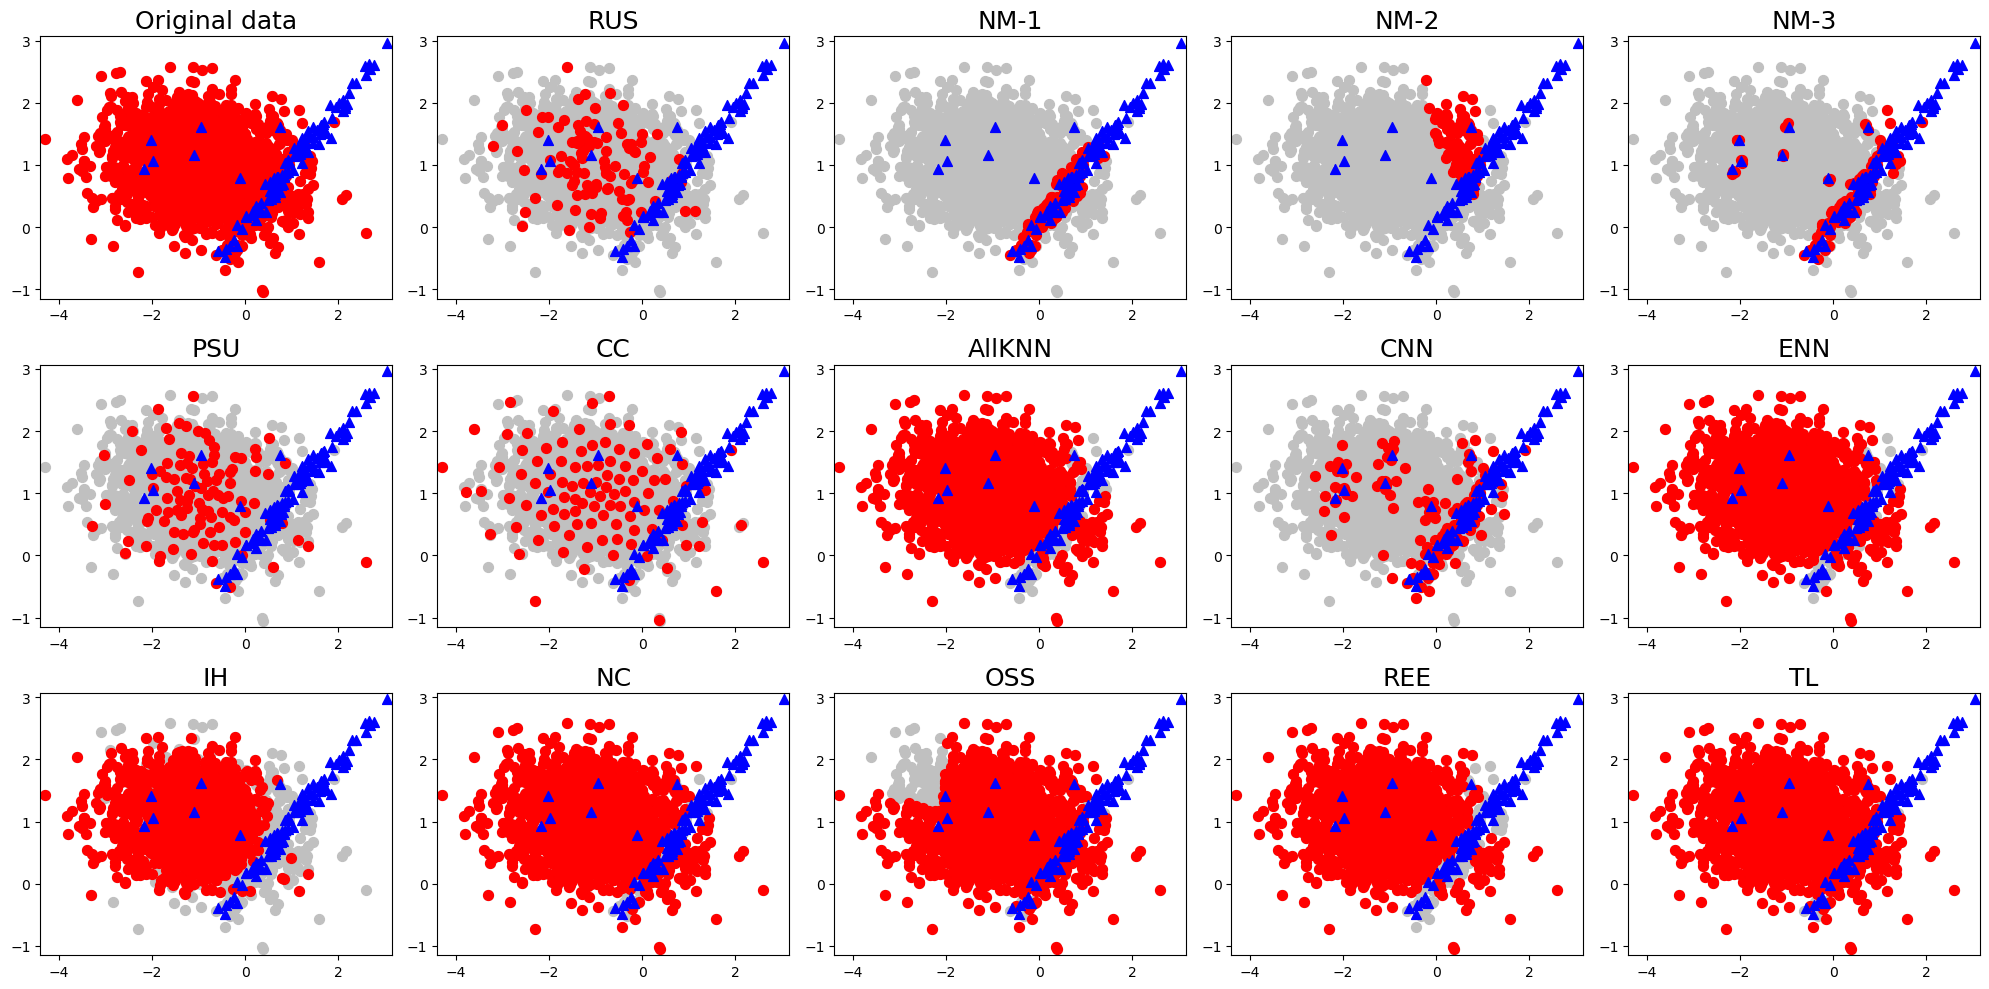

In [3]:
from matplotlib.ticker import MaxNLocator

dataset, labels = make_classification(n_samples=2000, n_features=2, n_informative=2,
                                       n_redundant=0, n_clusters_per_class=1,
                                       weights=[0.95, 0.05], class_sep=1.0,
                                       random_state=42)


methods = ["RUS", "NM-1", "NM-2", "NM-3", "PSU", "PSU-m", "CC", 
           "ALLKNN", "CNN", "ENN", "IH", "NC", "OSS", "REE", "TL"]


def resampling(X, y, method, seed):
    if method == "RUS":
        return imblearn.under_sampling.RandomUnderSampler(random_state = seed).fit_resample(X, y)
    if method == "NM-1":
        return imblearn.under_sampling.NearMiss(version = 1).fit_resample(X, y)
    if method == "NM-2":
        return imblearn.under_sampling.NearMiss(version = 2).fit_resample(X, y)
    if method == "NM-3":
        return imblearn.under_sampling.NearMiss(version = 3).fit_resample(X, y)
    if method == "PSU":
        return PSU(X, y)
    if method == "PSU-m":
        return PSUm(X, y)
    if method == "PSU-mm":
        return PSUmm(X, y)
    if method == "CC":
        return imblearn.under_sampling.ClusterCentroids(random_state = seed).fit_resample(X, y)
    if method == "AllKNN":
        return imblearn.under_sampling.AllKNN().fit_resample(X, y)
    if method == "CNN":
        return imblearn.under_sampling.CondensedNearestNeighbour().fit_resample(X, y)
    if method == "ENN":
        return imblearn.under_sampling.EditedNearestNeighbours().fit_resample(X, y)
    if method == "IH":
        return imblearn.under_sampling.InstanceHardnessThreshold().fit_resample(X, y)
    if method == "NC":
        return imblearn.under_sampling.NeighbourhoodCleaningRule().fit_resample(X, y)
    if method == "OSS":
        return imblearn.under_sampling.OneSidedSelection().fit_resample(X, y)
    if method == "REE":
        return imblearn.under_sampling.RepeatedEditedNearestNeighbours().fit_resample(X, y)
    if method == "TL":
        return imblearn.under_sampling.TomekLinks().fit_resample(X, y)
    
fig, axs = plt.subplots(3, 5, figsize = (20, 10))

locations = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4),
             (1, 0), (1, 1), (1, 2), (1, 3), (1, 4),
             (2, 0), (2, 1), (2, 2), (2, 3), (2, 4)]

ss = 50

for i0, method in enumerate(["Original data", "RUS", "NM-1", "NM-2", "NM-3", "PSU", 
                             "CC", "AllKNN", "CNN", "ENN", "IH", "NC", "OSS", "REE", "TL"]):
    
    if method == "Original data":
        re_data, re_label = dataset, labels
    else:
        re_data, re_label = resampling(dataset, labels, method, 0)
    
    axs[locations[i0]].set_title(str(method), fontsize = 18)
    gap = 0.1
    axs[locations[i0]].set_xlim(dataset[:,0].min() - gap, dataset[:,0].max() + gap)
    axs[locations[i0]].set_ylim(dataset[:,1].min() - gap, dataset[:,1].max() + gap)
    
    axs[locations[i0]].xaxis.set_major_locator(MaxNLocator(5))
    axs[locations[i0]].yaxis.set_major_locator(MaxNLocator(5))
    
    axs[locations[i0]].scatter(dataset[labels == 0, 0],
                               dataset[labels == 0, 1],
                               color = "silver",
                               s = ss)
    
    axs[locations[i0]].scatter(re_data[re_label == 0, 0], 
                               re_data[re_label == 0, 1],
                               color = "red",
                               marker = "o",
                               s = ss)

    axs[locations[i0]].scatter(re_data[re_label == 1, 0], 
                               re_data[re_label == 1, 1],
                               color = "blue", 
                               marker = "^",
                               s = ss)
    
plt.tight_layout()
plt.show()

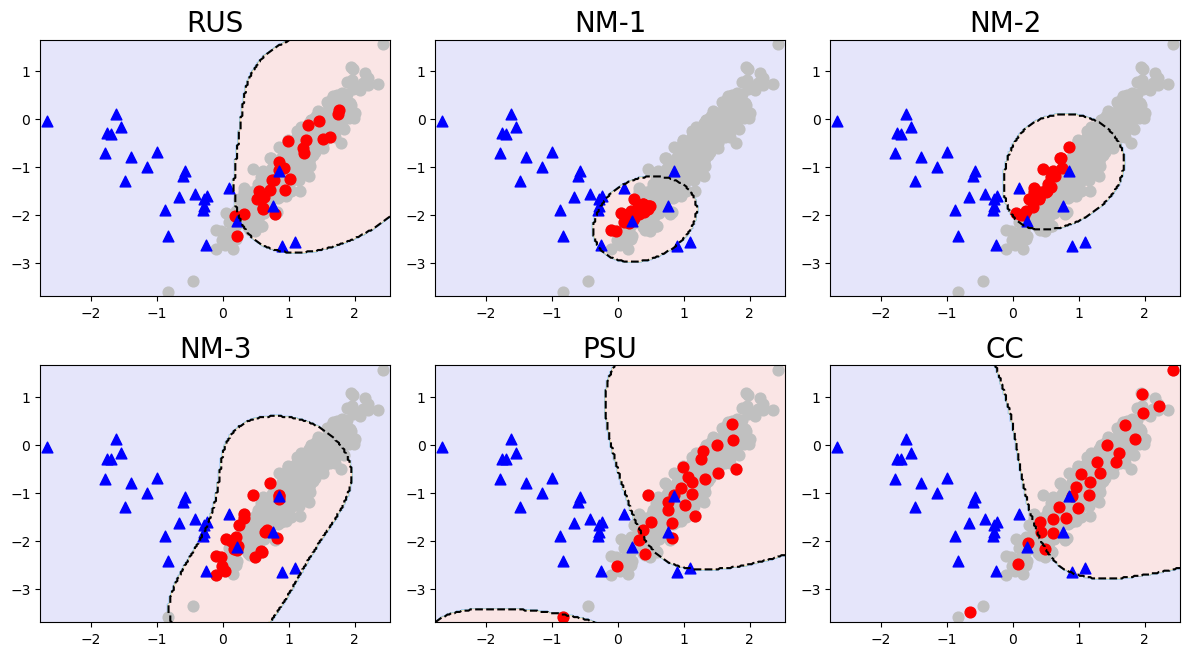

In [4]:
dataset, labels = make_classification(n_samples=500, n_features=2, n_informative=2,
                                           n_redundant=0, n_clusters_per_class=1,
                                           weights=[0.95, 0.05], class_sep = 1,
                                           random_state=1915)


fig, axs = plt.subplots(2, 3, figsize = (20/5*3, 10/3*2))

locations = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

ss = 60

for i0, method in enumerate(["RUS", "NM-1", "NM-2", "NM-3", "PSU", "CC"]):
    
    gap = 0.1
    
    xmax, xmin = np.max(dataset[:,0]) + gap, np.min(dataset[:,0]) - gap
    ymax, ymin = np.max(dataset[:,1]) + gap, np.min(dataset[:,1]) - gap
    
    if method == "Original data":
        re_data, re_label = dataset, labels
    else:
        re_data, re_label = resampling(dataset, labels, method, 0)
    
    
    model = svm.SVC(kernel = "rbf")
    model.fit(re_data, re_label)
    
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 200),
                         np.linspace(ymin, ymax, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axs[locations[i0]].contourf(xx, yy, Z, cmap=plt.cm.jet_r, alpha=0.1)
    axs[locations[i0]].contour(xx, yy, Z, levels=[0], colors='black',linestyles='dashed')

    
    axs[locations[i0]].set_xlim(dataset[:,0].min() - gap, dataset[:,0].max() + gap)
    axs[locations[i0]].set_ylim(dataset[:,1].min() - gap, dataset[:,1].max() + gap)
    
    axs[locations[i0]].set_title(str(method), fontsize = 20)
    
    axs[locations[i0]].scatter(dataset[labels == 0, 0],
                               dataset[labels == 0, 1],
                               color = "silver",
                               s = ss)
    
    axs[locations[i0]].scatter(re_data[re_label == 0, 0], 
                               re_data[re_label == 0, 1],
                               color = "red",
                               marker = "o",
                               s = ss)

    axs[locations[i0]].scatter(re_data[re_label == 1, 0], 
                               re_data[re_label == 1, 1],
                               color = "blue", 
                               marker = "^",
                               s = ss)

plt.tight_layout()
plt.show()

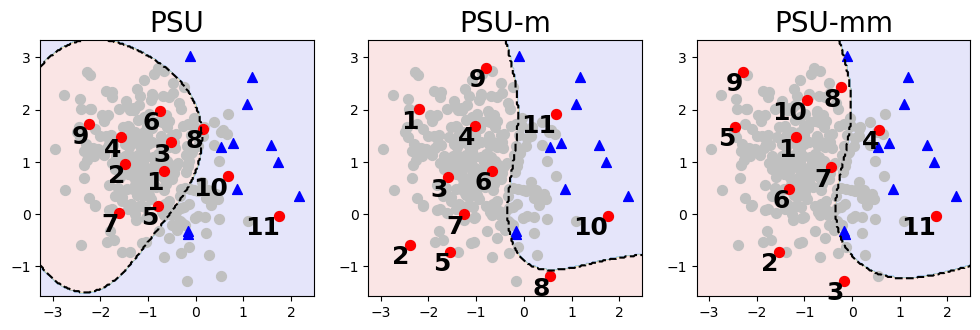

In [5]:
dataset, labels = make_classification(n_samples=300, n_features=2, n_informative=2,
                                       n_redundant=0, n_clusters_per_class=1,
                                       weights=[0.97, 0.03], class_sep=1.0,
                                       random_state=11)


fig, axs = plt.subplots(1, 3, figsize=(12, 3.33))

locations = [0, 1, 2]

ss = 50

title_fontsize = 20

for i0 in range(3):

    if i0 == 0:
        axs[locations[i0]].set_title("PSU", fontsize = title_fontsize)
        re_data, re_label = PSU(dataset, labels)

    if i0 == 1:
        axs[locations[i0]].set_title("PSU-m", fontsize = title_fontsize)
        re_data, re_label = PSUm(dataset, labels)
        
    if i0 == 2:
        axs[locations[i0]].set_title("PSU-mm", fontsize = title_fontsize)
        re_data, re_label = PSUmm(dataset, labels)

    re_data_major = re_data[re_label == 0]
    re_data_minor = re_data[re_label == 1]

    
    gap = 0.3
    
    xmax, xmin = np.max(dataset[:,0]) + gap, np.min(dataset[:,0]) - gap
    ymax, ymin = np.max(dataset[:,1]) + gap, np.min(dataset[:,1]) - gap
     
    model = svm.SVC(kernel = "rbf")
    model.fit(re_data, re_label)
    
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 200),
                         np.linspace(ymin, ymax, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axs[locations[i0]].contourf(xx, yy, Z, cmap=plt.cm.jet_r, alpha=0.1)
    axs[locations[i0]].contour(xx, yy, Z, levels=[0], colors='black',linestyles='dashed')
    
    axs[locations[i0]].set_xlim(dataset[:, 0].min() - gap, dataset[:, 0].max() + gap)
    axs[locations[i0]].set_ylim(dataset[:, 1].min() - gap, dataset[:, 1].max() + gap)

    axs[locations[i0]].scatter(dataset[labels == 0, 0], dataset[labels == 0, 1], color="silver", s=ss)
    axs[locations[i0]].scatter(dataset[labels == 1, 0], dataset[labels == 1, 1], color="blue", s=ss, marker = "^")

    for i1 in range(len(re_data_major)):
        axs[locations[i0]].scatter(re_data_major[i1, 0], re_data_major[i1, 1], color="red", marker="o", s = ss)
        axs[locations[i0]].text(re_data_major[i1, 0],  
                                re_data_major[i1, 1],  
                                str(i1 + 1),          
                                fontsize=18,
                                fontweight='bold',
                                horizontalalignment='right',
                                verticalalignment='top',
                                zorder=5)

plt.show()